A reworked version of https://www.kaggle.com/CVxTz/beating-the-baseline-keras-lb-0-38/code.

In [1]:
import os
from collections import defaultdict
import glob
import random

import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from keras.applications import resnet50
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, merge, Add
from keras.optimizers import Adam
from keras.layers import (
    Dropout, Conv2D, MaxPooling2D, Input,
    Dense, Flatten, GlobalMaxPooling2D, Lambda)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import (
    random_rotation, random_shift, random_shear, random_zoom,
    random_channel_shift, img_to_array)
from keras.utils import Sequence
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

%matplotlib inline

/home/lex/anaconda3/envs/humpback-whale/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
_MODEL = resnet50.ResNet50
_preprocessor = resnet50.preprocess_input

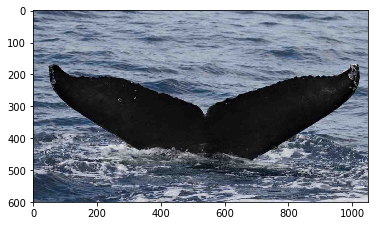

In [3]:
im = Image.open('./data/train/ff3509c0.jpg')
plt.imshow(im)

In [4]:
def load_image(filepath, input_shape):
    im = Image.open((filepath)).convert('RGB')
    im = im.resize(input_shape)

    return np.array(im, dtype=np.float32)


def random_greyscale(img, p):
    if random.random() < p:
        img = np.dot(img[...,:3], [0.299, 0.587, 0.114])
        # Ensure we have 3 channels
        return np.stack((img,)*3, axis=-1)
    
    return img


def augmentation_pipeline(img_arr):
    img_arr = random_rotation(img_arr, 18, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_shear(img_arr, intensity=0.4, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_zoom(img_arr, zoom_range=(0.9, 2.0), row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_greyscale(img_arr, 0.4)

    return img_arr

In [5]:
class TripletGenerator(Sequence):
    
    """Generate batches of triplets from a DataFrame."""

    def __init__(
        self, df, preprocessor=None, augmentation_pipeline=None, batch_size=8,
        img_root="data/train/", input_shape=(256, 256), other_id='new_whale'
    ):
        self.preprocessor = preprocessor
        self.batch_size = batch_size
        self.img_root = img_root
        self.input_shape = input_shape
        self.other_id = other_id
        self.augmentation_pipeline = augmentation_pipeline
        
        self.image_to_id = {k: v for k, v in zip(df.Image.values, df.Id.values)}
        
        self.all_files = list(self.image_to_id.keys())
        self.all_files_range = list(range(len(self.all_files)))
        
        self.id_to_images = defaultdict(list)
        for img_filepath, id_ in self.image_to_id.items():
            if id_ != other_id:
                self.id_to_images[id_].append(img_filepath)
                
        self.class_list = list(self.id_to_images.keys())
        self.class_list_range = range(len(self.class_list))
        
        class_sizes = np.array([
            len(self.id_to_images[class_]) for class_ in self.class_list])
        self.class_weights = class_sizes / np.sum(class_sizes)
        
    def __len__(self):
        return len(self.image_to_id)
    
    def get_next_files(self):
        # Get a random class index.
        class_idx = np.random.choice(self.class_list_range, 1, p=self.class_weights)[0]
        class_imgs = self.id_to_images[self.class_list[class_idx]]
        
        # Get random images from the class.
        anchor_idx, positive_idx = np.random.choice(range(len(class_imgs)), 2)
        
        # Get the filenames from the original set.
        anchor_filename, positive_filename = (
            class_imgs[anchor_idx], class_imgs[positive_idx])

        # Get a negative example, ensuring it's not from the class.
        negative_filename = None
        while negative_filename is None or (
            self.image_to_id[negative_filename] ==
            self.image_to_id[positive_filename]
        ):
            negative_idx = np.random.choice(self.all_files_range, 1)[0]
            negative_filename = self.all_files[negative_idx]
            
        return anchor_filename, positive_filename, negative_filename
    
    def __next__(self):
        return self[0]
    
    def __iter__(self):
        return self
    
    def __getitem__(self, idx):
        anchor_filename, positive_filename, negative_filename = self.get_next_files()

        anchor_imgs = []
        negative_imgs = []
        positive_imgs = []
        
        for i in range(self.batch_size):
            anchor_filename, positive_filename, negative_filename = self.get_next_files()

            anchor_img, positive_img, negative_img = (
                load_image(f'{self.img_root}/{anchor_filename}', input_shape=self.input_shape),
                load_image(f'{self.img_root}/{positive_filename}', input_shape=self.input_shape),
                load_image(f'{self.img_root}/{negative_filename}', input_shape=self.input_shape))
            
            if self.preprocessor:
                anchor_img, positive_img, negative_img = (
                    self.preprocessor(anchor_img),
                    self.preprocessor(positive_img),
                    self.preprocessor(negative_img))
                
                
            if self.augmentation_pipeline:
                anchor_img, positive_img, negative_img  = (
                    self.augmentation_pipeline(anchor_img),
                    self.augmentation_pipeline(positive_img),
                    self.augmentation_pipeline(negative_img))

            anchor_imgs.append(anchor_img)
            positive_imgs.append(positive_img)
            negative_imgs.append(negative_img)

        anchor_imgs = np.array(anchor_imgs)
        positive_imgs = np.array(positive_imgs)
        negative_imgs = np.array(negative_imgs)

        return [anchor_imgs, positive_imgs, negative_imgs], np.ones(self.batch_size)

In [6]:
data = pd.read_csv('data/train.csv')

next_x, next_y = next(TripletGenerator(data, resnet50.preprocess_input))

In [7]:
def get_base_model(model=_MODEL, dropout=0.5, latent_dim=128):
    base_model = model(include_top=False)
    
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dropout(dropout)(x)
    
    x = Dense(latent_dim)(x)
    output = Lambda(lambda x: K.l2_normalize(x, axis=1))(x)
    
    base_model = Model(base_model.input, output, name="base_model")

    return base_model

In [8]:
def triplet_loss(y_pred, alpha=0.2):
    """
    Implemenatation of triplet loss from the assignment
    Face Recognition for the Happy House, taken from Andrew Ng's CNN Coursera course.
    
    y_true - true labels, required when defining a loss function in Keras.
    y_pred - Python list with 3 objects:
      anchor - encodings for anchor image of shape (None, 128)
      positive - encoding for positive image of shape (None, 128)
      negative - encoding for negative image of shape (None, 128)
      
    Return:
      loss - real number, value of loss.
    """
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_distance = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=1)
    neg_distance = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=1)
    basic_loss = tf.add(tf.subtract(pos_distance, neg_distance), alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    
    return loss

In [9]:
def identity_loss(y_true, y_pred):

    return K.mean(y_pred)

In [10]:
def build_model(input_shape=(256, 256)):
    base_model = get_base_model()
    
    anchor = Input(input_shape + (3,) , name='anchor')
    positive = Input(input_shape + (3,) , name='positive')
    negative = Input(input_shape + (3,) , name='negative')
    
    anchor_out = base_model(anchor)
    positive_out = base_model(positive)
    negative_out = base_model(negative)
    
    output = Lambda(triplet_loss, output_shape=(1,))([anchor_out, positive_out, negative_out])

    model = Model(inputs=[anchor, positive, negative], outputs=output)

    model.compile(loss=identity_loss, optimizer=Adam(0.000001))

    return model

In [11]:
data = pd.read_csv('data/train.csv')
train, test = train_test_split(data, test_size=0.3, shuffle=True, random_state=1337)

train_gen = TripletGenerator(train, preprocessor=_preprocessor) #  augmentation_pipeline=augmentation_pipeline)
test_gen = TripletGenerator(test, preprocessor=_preprocessor, augmentation_pipeline=None)

In [12]:
x_batch, y_batch = train_gen[0]

In [13]:
print(x_batch[0][0].dtype)

float32


In [14]:
x_batch[0].shape

(8, 256, 256, 3)

In [15]:
model = build_model()

In [16]:
model.compile(loss=identity_loss, optimizer=Adam(0.00001))

In [17]:
model_path = f'./data/checkpoints/resnet50_v3.h5'
callbacks = [
    ModelCheckpoint(model_path, save_best_only=True),
    ReduceLROnPlateau(patience=3, verbose=True),
    EarlyStopping(patience=5)]

In [18]:
history = model.fit_generator(
    train_gen,
    validation_data=test_gen,
    epochs=10, callbacks=callbacks, steps_per_epoch=300,
    validation_steps=30, workers=4, use_multiprocessing=True)

Epoch 1/10
300/300 [==============================] - 347s 1s/step - loss: 0.3992 - val_loss: 0.2752
Epoch 2/10
300/300 [==============================] - 334s 1s/step - loss: 0.3673 - val_loss: 0.3117
Epoch 3/10
300/300 [==============================] - 334s 1s/step - loss: 0.3200 - val_loss: 0.2819
Epoch 4/10
300/300 [==============================] - 335s 1s/step - loss: 0.2856 - val_loss: 0.2247
Epoch 5/10
300/300 [==============================] - 335s 1s/step - loss: 0.2257 - val_loss: 0.1942
Epoch 6/10
300/300 [==============================] - 334s 1s/step - loss: 0.2638 - val_loss: 0.1603
Epoch 7/10
300/300 [==============================] - 333s 1s/step - loss: 0.1458 - val_loss: 0.2803
Epoch 8/10
300/300 [==============================] - 333s 1s/step - loss: 0.1587 - val_loss: 0.3449
Epoch 9/10
300/300 [==============================] - 333s 1s/step - loss: 0.1496 - val_loss: 0.3532
Epoch 10/10
299/300 [============================>.] - ETA: 1s - loss: 0.1477
Epoch 00010: 

In [19]:
K.set_value(model.optimizer.lr, 0.00001)

In [20]:
history = model.fit_generator(
    train_gen,
    validation_data=test_gen,
    epochs=10, callbacks=callbacks, steps_per_epoch=300,
    validation_steps=30, workers=4, use_multiprocessing=True)

Epoch 1/10
300/300 [==============================] - 333s 1s/step - loss: 0.0826 - val_loss: 0.2986
Epoch 2/10
300/300 [==============================] - 333s 1s/step - loss: 0.0701 - val_loss: 0.2481
Epoch 3/10
300/300 [==============================] - 333s 1s/step - loss: 0.0681 - val_loss: 0.2128
Epoch 4/10
300/300 [==============================] - 333s 1s/step - loss: 0.0360 - val_loss: 0.1864
Epoch 5/10
300/300 [==============================] - 333s 1s/step - loss: 0.0343 - val_loss: 0.2169
Epoch 6/10
300/300 [==============================] - 333s 1s/step - loss: 0.0310 - val_loss: 0.2025
Epoch 7/10
300/300 [==============================] - 333s 1s/step - loss: 0.0226 - val_loss: 0.2207
Epoch 8/10
299/300 [============================>.] - ETA: 1s - loss: 0.0192
Epoch 00008: reducing learning rate to 9.999999747378752e-07.
300/300 [==============================] - 333s 1s/step - loss: 0.0199 - val_loss: 0.1921
Epoch 9/10
300/300 [==============================] - 333s 1s/st

In [22]:
model.load_weights(f'./data/checkpoints/resnet50_v3.h5')

In [23]:
def get_inference_model(model):
    inference_model = Model(
        inputs=model.get_layer('base_model').get_input_at(0),
        output=model.get_layer('base_model').get_output_at(0))
    inference_model.compile(loss="mse", optimizer=Adam(0.000001))
    return inference_model

In [28]:
model_name = "triplet_loss"

def data_generator(fpaths, batch=16):
    i = 0
    for path in fpaths:
        if i == 0:
            imgs = []
            fnames = []
        i += 1
        img = load_image(path, input_shape=(256, 256))
        imgs.append(img)
        fnames.append(os.path.basename(path))
        if i == batch:
            i = 0
            imgs = np.array(imgs)
            yield fnames, imgs

    if i < batch:
        imgs = np.array(imgs)
        yield fnames, imgs

    raise StopIteration()

inference_model = get_inference_model(model)

train_files = glob.glob("data/train/*.jpg")
test_files = glob.glob("data/test/*.jpg")

/home/lex/anaconda3/envs/humpback-whale/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`
  after removing the cwd from sys.path.


In [29]:
train_preds = []
train_file_names = []
i = 1
for fnames, imgs in tqdm(data_generator(train_files, batch=32), total=len(train_files) // 32):
    i += 1
    predicts = inference_model.predict(imgs)
    predicts = predicts.tolist()
    train_preds += predicts
    train_file_names += fnames

train_preds = np.array(train_preds)

test_preds = []
test_file_names = []
for fnames, imgs in tqdm(data_generator(test_files, batch=32), total=len(test_files) // 32):
    predicts = inference_model.predict(imgs)
    predicts = predicts.tolist()
    test_preds += predicts
    test_file_names += fnames

test_preds = np.array(test_preds)



  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 1/307 [00:03<19:27,  3.82s/it]

  1%|          | 2/307 [00:04<11:14,  2.21s/it]

  1%|          | 3/307 [00:05<08:30,  1.68s/it]

  1%|▏         | 4/307 [00:05<07:06,  1.41s/it]

  2%|▏         | 5/307 [00:06<06:16,  1.25s/it]

  2%|▏         | 6/307 [00:06<05:42,  1.14s/it]

  2%|▏         | 7/307 [00:07<05:18,  1.06s/it]

  3%|▎         | 8/307 [00:08<05:00,  1.01s/it]

  3%|▎         | 9/307 [00:08<04:46,  1.04it/s]

  3%|▎         | 10/307 [00:09<04:35,  1.08it/s]

  4%|▎         | 11/307 [00:09<04:25,  1.11it/s]

  4%|▍         | 12/307 [00:10<04:17,  1.15it/s]

  4%|▍         | 13/307 [00:11<04:10,  1.17it/s]

  5%|▍         | 14/307 [00:11<04:04,  1.20it/s]

  5%|▍         | 15/307 [00:12<03:59,  1.22it/s]

  5%|▌         | 16/307 [00:12<03:55,  1.24it/s]

  6%|▌         | 17/307 [00:13<03:50,  1.26it/s]

  6%|▌         | 18/307 [00:14<03:46,  1.27it/s]

  6%|▌         | 19/307 [00:14<03:43,  1.29it/s]

  7%|▋         |

 47%|████▋     | 145/307 [01:30<01:41,  1.60it/s]

 48%|████▊     | 146/307 [01:31<01:40,  1.60it/s]

 48%|████▊     | 147/307 [01:31<01:39,  1.60it/s]

 48%|████▊     | 148/307 [01:32<01:39,  1.60it/s]

 49%|████▊     | 149/307 [01:32<01:38,  1.60it/s]

 49%|████▉     | 150/307 [01:33<01:37,  1.60it/s]

 49%|████▉     | 151/307 [01:34<01:37,  1.61it/s]

 50%|████▉     | 152/307 [01:34<01:36,  1.61it/s]

 50%|████▉     | 153/307 [01:35<01:35,  1.61it/s]

 50%|█████     | 154/307 [01:35<01:35,  1.61it/s]

 50%|█████     | 155/307 [01:36<01:34,  1.61it/s]

 51%|█████     | 156/307 [01:37<01:33,  1.61it/s]

 51%|█████     | 157/307 [01:37<01:33,  1.61it/s]

 51%|█████▏    | 158/307 [01:38<01:32,  1.61it/s]

 52%|█████▏    | 159/307 [01:38<01:32,  1.61it/s]

 52%|█████▏    | 160/307 [01:39<01:31,  1.61it/s]

 52%|█████▏    | 161/307 [01:40<01:30,  1.61it/s]

 53%|█████▎    | 162/307 [01:40<01:30,  1.61it/s]

 53%|█████▎    | 163/307 [01:41<01:29,  1.61it/s]

 53%|█████▎    | 164/307 [01:41

 94%|█████████▍| 288/307 [02:56<00:11,  1.63it/s]

 94%|█████████▍| 289/307 [02:57<00:11,  1.63it/s]

 94%|█████████▍| 290/307 [02:58<00:10,  1.63it/s]

 95%|█████████▍| 291/307 [02:58<00:09,  1.63it/s]

 95%|█████████▌| 292/307 [02:59<00:09,  1.63it/s]

 95%|█████████▌| 293/307 [02:59<00:08,  1.63it/s]

 96%|█████████▌| 294/307 [03:00<00:07,  1.63it/s]

 96%|█████████▌| 295/307 [03:01<00:07,  1.63it/s]

 96%|█████████▋| 296/307 [03:01<00:06,  1.63it/s]

 97%|█████████▋| 297/307 [03:02<00:06,  1.63it/s]

 97%|█████████▋| 298/307 [03:02<00:05,  1.63it/s]

 97%|█████████▋| 299/307 [03:03<00:04,  1.63it/s]

 98%|█████████▊| 300/307 [03:04<00:04,  1.63it/s]

 98%|█████████▊| 301/307 [03:04<00:03,  1.63it/s]

 98%|█████████▊| 302/307 [03:05<00:03,  1.63it/s]

 99%|█████████▊| 303/307 [03:05<00:02,  1.63it/s]

 99%|█████████▉| 304/307 [03:06<00:01,  1.63it/s]

 99%|█████████▉| 305/307 [03:07<00:01,  1.63it/s]

100%|█████████▉| 306/307 [03:07<00:00,  1.63it/s]

100%|██████████| 307/307 [03:08

 25%|██▌       | 124/487 [01:18<03:48,  1.59it/s]

 26%|██▌       | 125/487 [01:18<03:47,  1.59it/s]

 26%|██▌       | 126/487 [01:19<03:47,  1.59it/s]

 26%|██▌       | 127/487 [01:19<03:46,  1.59it/s]

 26%|██▋       | 128/487 [01:20<03:45,  1.59it/s]

 26%|██▋       | 129/487 [01:21<03:45,  1.59it/s]

 27%|██▋       | 130/487 [01:21<03:44,  1.59it/s]

 27%|██▋       | 131/487 [01:22<03:43,  1.59it/s]

 27%|██▋       | 132/487 [01:22<03:43,  1.59it/s]

 27%|██▋       | 133/487 [01:23<03:42,  1.59it/s]

 28%|██▊       | 134/487 [01:24<03:41,  1.59it/s]

 28%|██▊       | 135/487 [01:24<03:41,  1.59it/s]

 28%|██▊       | 136/487 [01:25<03:40,  1.59it/s]

 28%|██▊       | 137/487 [01:26<03:39,  1.59it/s]

 28%|██▊       | 138/487 [01:26<03:39,  1.59it/s]

 29%|██▊       | 139/487 [01:27<03:38,  1.59it/s]

 29%|██▊       | 140/487 [01:27<03:37,  1.59it/s]

 29%|██▉       | 141/487 [01:28<03:37,  1.59it/s]

 29%|██▉       | 142/487 [01:29<03:36,  1.59it/s]

 29%|██▉       | 143/487 [01:29

 55%|█████▍    | 267/487 [02:46<02:17,  1.60it/s]

 55%|█████▌    | 268/487 [02:47<02:16,  1.60it/s]

 55%|█████▌    | 269/487 [02:47<02:15,  1.60it/s]

 55%|█████▌    | 270/487 [02:48<02:15,  1.60it/s]

 56%|█████▌    | 271/487 [02:48<02:14,  1.61it/s]

 56%|█████▌    | 272/487 [02:49<02:13,  1.60it/s]

 56%|█████▌    | 273/487 [02:50<02:13,  1.60it/s]

 56%|█████▋    | 274/487 [02:50<02:12,  1.61it/s]

 56%|█████▋    | 275/487 [02:51<02:12,  1.61it/s]

 57%|█████▋    | 276/487 [02:51<02:11,  1.61it/s]

 57%|█████▋    | 277/487 [02:52<02:10,  1.61it/s]

 57%|█████▋    | 278/487 [02:53<02:10,  1.61it/s]

 57%|█████▋    | 279/487 [02:53<02:09,  1.61it/s]

 57%|█████▋    | 280/487 [02:54<02:08,  1.61it/s]

 58%|█████▊    | 281/487 [02:54<02:08,  1.61it/s]

 58%|█████▊    | 282/487 [02:55<02:07,  1.61it/s]

 58%|█████▊    | 283/487 [02:56<02:07,  1.61it/s]

 58%|█████▊    | 284/487 [02:56<02:06,  1.61it/s]

 59%|█████▊    | 285/487 [02:57<02:05,  1.61it/s]

 59%|█████▊    | 286/487 [02:58

 84%|████████▍ | 410/487 [04:13<00:47,  1.61it/s]

 84%|████████▍ | 411/487 [04:14<00:47,  1.62it/s]

 85%|████████▍ | 412/487 [04:15<00:46,  1.62it/s]

 85%|████████▍ | 413/487 [04:15<00:45,  1.62it/s]

 85%|████████▌ | 414/487 [04:16<00:45,  1.62it/s]

 85%|████████▌ | 415/487 [04:16<00:44,  1.62it/s]

 85%|████████▌ | 416/487 [04:17<00:43,  1.62it/s]

 86%|████████▌ | 417/487 [04:18<00:43,  1.62it/s]

 86%|████████▌ | 418/487 [04:18<00:42,  1.61it/s]

 86%|████████▌ | 419/487 [04:19<00:42,  1.62it/s]

 86%|████████▌ | 420/487 [04:20<00:41,  1.62it/s]

 86%|████████▋ | 421/487 [04:20<00:40,  1.61it/s]

 87%|████████▋ | 422/487 [04:21<00:40,  1.62it/s]

 87%|████████▋ | 423/487 [04:21<00:39,  1.62it/s]

 87%|████████▋ | 424/487 [04:22<00:39,  1.62it/s]

 87%|████████▋ | 425/487 [04:23<00:38,  1.62it/s]

 87%|████████▋ | 426/487 [04:23<00:37,  1.62it/s]

 88%|████████▊ | 427/487 [04:24<00:37,  1.62it/s]

 88%|████████▊ | 428/487 [04:24<00:36,  1.62it/s]

 88%|████████▊ | 429/487 [04:25

In [31]:
neigh = NearestNeighbors(n_neighbors=6)
neigh.fit(train_preds)

distances_test, neighbors_test = neigh.kneighbors(test_preds)
distances_test, neighbors_test = distances_test.tolist(), neighbors_test.tolist()

preds_str = []

file_id_mapping = {k: v for k, v in zip(data.Image.values, data.Id.values)}

for filepath, distance, neighbour_ in zip(test_file_names, distances_test, neighbors_test):
    sample_result = []
    sample_classes = []
    for d, n in zip(distance, neighbour_):
        train_file = train_files[n].split(os.sep)[-1]
        class_train = file_id_mapping[train_file]
        sample_classes.append(class_train)
        sample_result.append((class_train, d))

    if "new_whale" not in sample_classes:
        sample_result.append(("new_whale", 0.1))
    sample_result.sort(key=lambda x: x[1])
    sample_result = sample_result[:5]
    preds_str.append(" ".join([x[0] for x in sample_result]))

df = pd.DataFrame(preds_str, columns=["Id"])
df['Image'] = [x.split(os.sep)[-1] for x in test_file_names]

In [32]:
df.to_csv('data/submissions/triplet_loss_more_training_v1.csv.gz', index=False, compression='gzip')

In [33]:
from IPython.display import FileLink

In [34]:
FileLink('data/submissions/triplet_loss_more_training_v1.csv.gz')

/home/lex/kaggle-whale-categorization/data/submissions/triplet_loss_more_training_v1.csv.gz

Score: 0.411554. Puts me at third.